<a href="https://colab.research.google.com/github/geekevgin/-Python/blob/main/BelEvSer_NLP_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=4486a6feff499bf5f40718916d189a16886081b860f14e527f5094f20ef46d02
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
!pip install stop_words


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=6b92dffc28ef7a2c9af1d64e4d898a5c8d4cf440c317af04ea58e9e8cec16da2
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [33]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, GlobalAveragePooling1D, AveragePooling1D,add,Flatten
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping 
from gensim.models import Word2Vec
import multiprocessing
from keras.utils import pad_sequences
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt


     

In [5]:
from google.colab import files
uploaded = files.upload()

Saving отзывы за лето.xls to отзывы за лето.xls


In [6]:
max_words = 2000
max_len = 50
epochs = 20
batch_size = 5000
vec_len = 10
N_CLASSES = 2
seed = 42
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

data = pd.read_excel('отзывы за лето.xls', parse_dates=[2])

TARGET = 'target'
PROCESSED = 'preprocessed'

In [7]:
data =pd.read_excel('./отзывы за лето.xls')
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [17]:
def preprocess_text(txt): #препроцессинг
    
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

def prepare_data(df: pd.DataFrame,
                 n_classes: int,
                 processed_field: str = PROCESSED,
                 target_field: str = TARGET) -> pd.DataFrame:
    
    assert n_classes in [2,5], 'Bad Number of classes'
    
    print(f"Data preparing...", end="")

    df[processed_field] = df['Content'].apply(preprocess_text)
    
    if n_classes == 2:
        df = df[df['Rating'] != 3]
        df[target_field] = (df['Rating'] > 3).astype('uint8')   #Преобразование таргета в one-hot encoding

        
    else:
        df[target_field] = df['Rating'] - 1
    
    return df

def get_splits(data, seed=seed): #Разделение датасета на 3 сплита в пропорции 

    train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=seed)
    valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=seed)
    
    return train, valid, test

def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(8,2))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()


In [9]:
data = prepare_data(df=data, n_classes=N_CLASSES)
df_train, df_val, df_test = get_splits(data)

text_corpus_train = df_train[PROCESSED].values
text_corpus_valid = df_val[PROCESSED].values
text_corpus_test = df_test[PROCESSED].values

tokenizer = Tokenizer(num_words=None, 
                      lower = False,
                      split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)

y_train = df_train[TARGET].values
y_val = df_val[TARGET].values
y_test = df_test[TARGET].values

Data preparing...

<ipython-input-8-da3fd917c2a4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_field] = (df['Rating'] > 3).astype('uint8')   #Преобразование таргета в one-hot encoding


In [12]:
#RNN

In [13]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(SimpleRNN(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history_RNN = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 9s 494ms/step - loss: 0.6559 - accuracy: 0.6081 - val_loss: 0.4366 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 4s 281ms/step - loss: 0.4632 - accuracy: 0.8429 - val_loss: 0.5169 - val_accuracy: 0.8354


In [14]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 2s 150ms/step - loss: 0.4915 - accuracy: 0.8440


Test score: 0.49154365062713623
Test accuracy: 0.8440243005752563


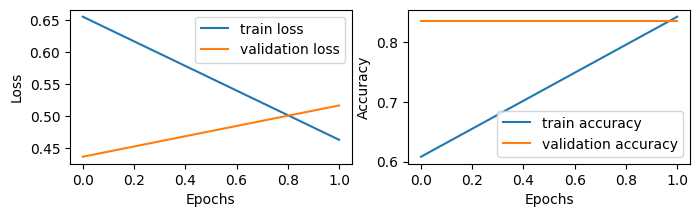

In [18]:
plot_history(history_RNN)

In [25]:
#LSTM Model

In [20]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history_LSTM = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 19s 912ms/step - loss: 0.6172 - accuracy: 0.8007 - val_loss: 0.4161 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 12s 877ms/step - loss: 0.4045 - accuracy: 0.8488 - val_loss: 0.3781 - val_accuracy: 0.8354
Epoch 3/10
14/14 [==============================] - 12s 875ms/step - loss: 0.3444 - accuracy: 0.8489 - val_loss: 0.3256 - val_accuracy: 0.8392
Epoch 4/10
14/14 [==============================] - 11s 816ms/step - loss: 0.2899 - accuracy: 0.8832 - val_loss: 0.2839 - val_accuracy: 0.8810
Epoch 5/10
14/14 [==============================] - 11s 763ms/step - loss: 0.2469 - accuracy: 0.9079 - val_loss: 0.2587 - val_accuracy: 0.8937
Epoch 6/10
14/14 [==============================] - 12s 822ms/step - loss: 0.2046 - accuracy: 0.9204 - val_loss: 0.2354 - val_accuracy: 0.8987
Epoch 7/10
14/14 [==============================] - 12s 871ms/step - loss: 0.1711 - accuracy: 0.9339 - val_loss: 0.2173 - val_accuracy: 0.9089

In [21]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])
     

12/12 [==============================] - 2s 178ms/step - loss: 0.2026 - accuracy: 0.9142


Test score: 0.2026350349187851
Test accuracy: 0.9142471551895142


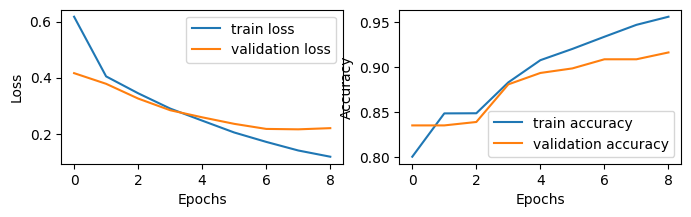

In [22]:
plot_history(history_LSTM)

In [27]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     

early_stopping=EarlyStopping(monitor='val_loss')  


history_Conv1D = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 6s 280ms/step - loss: 0.6448 - accuracy: 0.8488 - val_loss: 0.5756 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 3s 188ms/step - loss: 0.4874 - accuracy: 0.8488 - val_loss: 0.4356 - val_accuracy: 0.8354
Epoch 3/10
14/14 [==============================] - 4s 262ms/step - loss: 0.4065 - accuracy: 0.8488 - val_loss: 0.4092 - val_accuracy: 0.8354
Epoch 4/10
14/14 [==============================] - 2s 142ms/step - loss: 0.3435 - accuracy: 0.8488 - val_loss: 0.3193 - val_accuracy: 0.8354
Epoch 5/10
14/14 [==============================] - 2s 145ms/step - loss: 0.2392 - accuracy: 0.8488 - val_loss: 0.2255 - val_accuracy: 0.8354
Epoch 6/10
14/14 [==============================] - 2s 145ms/step - loss: 0.1602 - accuracy: 0.8488 - val_loss: 0.2017 - val_accuracy: 0.8354
Epoch 7/10
14/14 [==============================] - 2s 144ms/step - loss: 0.1246 - accuracy: 0.8488 - val_loss: 0.2076 - val_accuracy: 0.8354


In [28]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 38ms/step - loss: 0.1778 - accuracy: 0.8440


Test score: 0.17776264250278473
Test accuracy: 0.8440243005752563


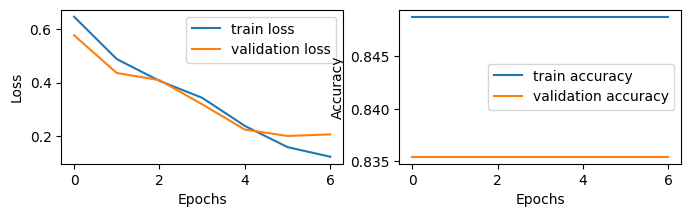

In [29]:
plot_history(history_Conv1D)

In [30]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3, activation='relu', padding="same"))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history_Conv_LSTM = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 19s 1s/step - loss: 0.5828 - accuracy: 0.8267 - val_loss: 0.4167 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 16s 1s/step - loss: 0.3803 - accuracy: 0.8488 - val_loss: 0.3469 - val_accuracy: 0.8354
Epoch 3/10
14/14 [==============================] - 16s 1s/step - loss: 0.3012 - accuracy: 0.8612 - val_loss: 0.2895 - val_accuracy: 0.8797
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 0.2381 - accuracy: 0.8998 - val_loss: 0.2482 - val_accuracy: 0.9013
Epoch 5/10
14/14 [==============================] - 17s 1s/step - loss: 0.1780 - accuracy: 0.9304 - val_loss: 0.2249 - val_accuracy: 0.9127
Epoch 6/10
14/14 [==============================] - 19s 1s/step - loss: 0.1324 - accuracy: 0.9508 - val_loss: 0.2346 - val_accuracy: 0.9203


In [31]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 3s 284ms/step - loss: 0.2216 - accuracy: 0.9105


Test score: 0.22157824039459229
Test accuracy: 0.9105334281921387


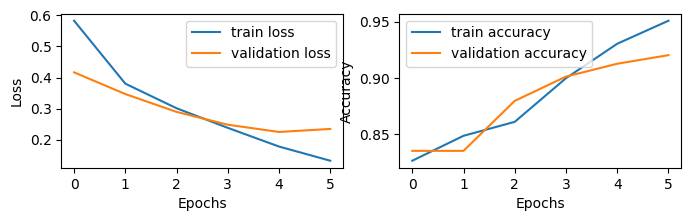

In [32]:
plot_history(history_Conv_LSTM)

In [35]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history_GRU = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 14s 780ms/step - loss: 0.6395 - accuracy: 0.8128 - val_loss: 0.5438 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 12s 821ms/step - loss: 0.4336 - accuracy: 0.8488 - val_loss: 0.3778 - val_accuracy: 0.8354
Epoch 3/10
14/14 [==============================] - 9s 621ms/step - loss: 0.3435 - accuracy: 0.8488 - val_loss: 0.3286 - val_accuracy: 0.8354
Epoch 4/10
14/14 [==============================] - 10s 729ms/step - loss: 0.2820 - accuracy: 0.8534 - val_loss: 0.2838 - val_accuracy: 0.8570
Epoch 5/10
14/14 [==============================] - 10s 733ms/step - loss: 0.2250 - accuracy: 0.9108 - val_loss: 0.2489 - val_accuracy: 0.9000
Epoch 6/10
14/14 [==============================] - 10s 738ms/step - loss: 0.1846 - accuracy: 0.9339 - val_loss: 0.2390 - val_accuracy: 0.9076
Epoch 7/10
14/14 [==============================] - 9s 622ms/step - loss: 0.1533 - accuracy: 0.9432 - val_loss: 0.2340 - val_accuracy: 0.9101
E

In [36]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 3s 245ms/step - loss: 0.2173 - accuracy: 0.9060


Test score: 0.2173188030719757
Test accuracy: 0.9059756994247437


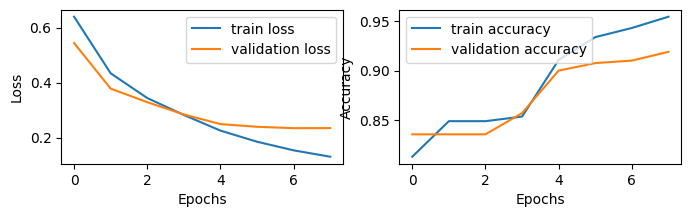

In [37]:
plot_history(history_GRU)

In [42]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3, activation='relu', padding="same"))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history_Conv_GRU = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
14/14 [==============================] - 19s 1s/step - loss: 0.6021 - accuracy: 0.8115 - val_loss: 0.4367 - val_accuracy: 0.8354
Epoch 2/10
14/14 [==============================] - 14s 988ms/step - loss: 0.3787 - accuracy: 0.8488 - val_loss: 0.3472 - val_accuracy: 0.8354
Epoch 3/10
14/14 [==============================] - 14s 1s/step - loss: 0.3057 - accuracy: 0.8488 - val_loss: 0.3051 - val_accuracy: 0.8354
Epoch 4/10
14/14 [==============================] - 23s 2s/step - loss: 0.2408 - accuracy: 0.8865 - val_loss: 0.2715 - val_accuracy: 0.8975
Epoch 5/10
14/14 [==============================] - 16s 1s/step - loss: 0.1794 - accuracy: 0.9335 - val_loss: 0.2605 - val_accuracy: 0.9063
Epoch 6/10
14/14 [==============================] - 16s 1s/step - loss: 0.1389 - accuracy: 0.9496 - val_loss: 0.2451 - val_accuracy: 0.9139
Epoch 7/10
14/14 [==============================] - 13s 973ms/step - loss: 0.1052 - accuracy: 0.9644 - val_loss: 0.2602 - val_accuracy: 0.9139


In [43]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 2s 185ms/step - loss: 0.2626 - accuracy: 0.9007


Test score: 0.26260384917259216
Test accuracy: 0.900742769241333


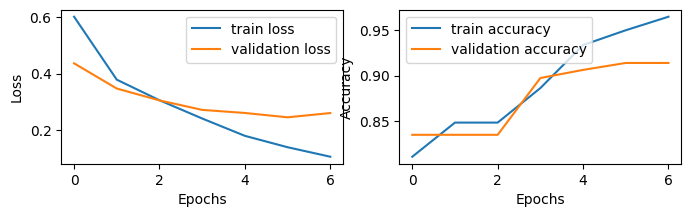

In [44]:
plot_history(history_Conv_GRU)

In [46]:
#Лучше всего сработала LSTM, LSTM-Conv, GRU средне, simpleRNN, Con отработали хуже всего